In [88]:
import json
import pandas as pd
with open("evaluation_results.json", "r", encoding="utf-8") as f:
    dataset = json.load(f)


df = pd.DataFrame(dataset)
print(f"Total experiments: {len(dataset)}")
df.head()

Total experiments: 1701


,question,answer,contexts,reference,prompt_tokens,completion_tokens,total_tokens,ttft,latency,namespace,top_k,context_precision,context_recall,faithfulness,answer_correctness
0,쿠버네티스가 무엇인가요?,"제공된 문서에서 해당 정보를 찾을 수 없습니다. [문서 1]에는 ""쿠버네티스는:""이...",[쿠버네티스는:],"쿠버네티스는 컨테이너화된 애플리케이션의 배포, 확장 및 관리를 자동화하기 위한 오픈...",177,44,469,5.230110,5.299407,cs256-ov0,1,0.0,0.0,0.666667,0.185127
1,쿠버네티스가 무엇인가요?,제공된 문서에서 해당 정보를 찾을 수 없습니다.,[쿠버네티스는:],"쿠버네티스는 컨테이너화된 애플리케이션의 배포, 확장 및 관리를 자동화하기 위한 오픈...",177,12,383,4.934436,4.936587,cs256-ov15,1,0.0,0.0,1.000000,0.129893
2,쿠버네티스가 무엇인가요?,"제공된 문서에서 해당 정보를 찾을 수 없습니다.\n\n[문서 1]에는 ""쿠버네티스는...",[쿠버네티스는:],"쿠버네티스는 컨테이너화된 애플리케이션의 배포, 확장 및 관리를 자동화하기 위한 오픈...",177,49,459,4.915990,4.918532,cs256-ov30,1,0.0,0.0,1.000000,0.182949
3,쿠버네티스가 무엇인가요?,"[문서 1]에 따르면, 쿠버네티스는 컨테이너화된 워크로드와 서비스를 관리하기 위한 ...",[---\n# reviewers:\n# - bgrant0607\n# - mikeda...,"쿠버네티스는 컨테이너화된 애플리케이션의 배포, 확장 및 관리를 자동화하기 위한 오픈...",390,81,919,5.922165,6.194015,cs512-ov0,1,1.0,1.0,1.000000,0.580690
4,쿠버네티스가 무엇인가요?,"문서 1에 따르면, 쿠버네티스에 대한 설명은 다음과 같습니다.\n\n* **명칭...",[<!-- overview -->\n이 페이지에서는 쿠버네티스 개요를 설명한다.\n...,"쿠버네티스는 컨테이너화된 애플리케이션의 배포, 확장 및 관리를 자동화하기 위한 오픈...",380,165,976,6.479982,6.950286,cs512-ov15,1,0.0,0.0,0.888889,0.191891


## 1. Top-K vs 품질 (Chunk 512 / Overlap 15%)

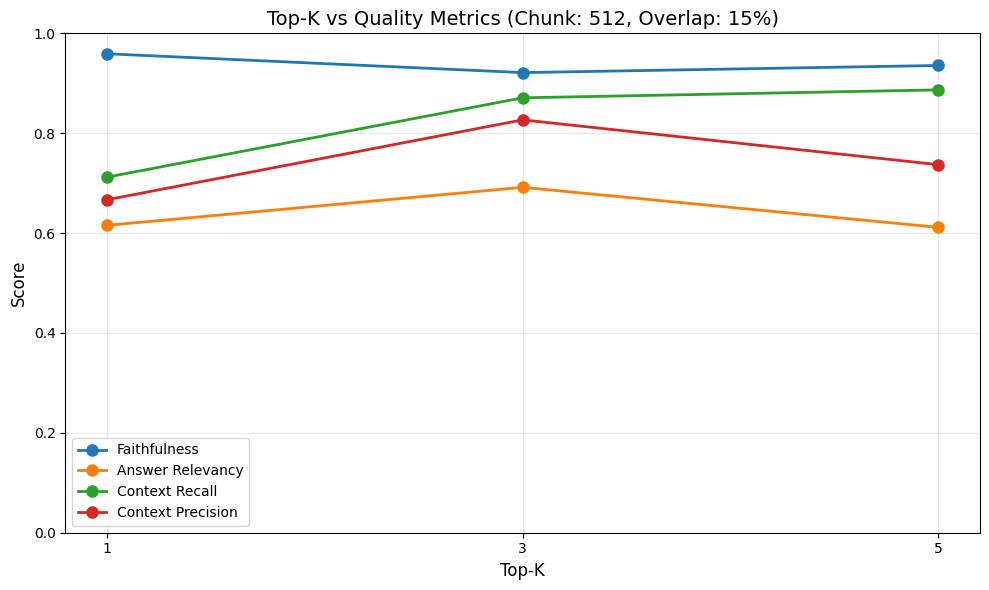

In [89]:
import matplotlib.pyplot as plt

metrics = ['faithfulness', 'answer_correctness',
           'context_recall', 'context_precision']
labels = ['Faithfulness', 'Answer Relevancy',
          'Context Recall', 'Context Precision']

df_filtered = df[df['namespace'] == 'cs512-ov15']
topk_means = df_filtered.groupby('top_k')[metrics].mean()

plt.figure(figsize=(10, 6))
for metric, label in zip(metrics, labels):
    plt.plot(topk_means.index, topk_means[metric],
             marker='o', linewidth=2, markersize=8, label=label)

plt.xlabel('Top-K', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Top-K vs Quality Metrics (Chunk: 512, Overlap: 15%)', fontsize=14)
plt.xticks([1, 3, 5])
plt.ylim(0, 1)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Top-K vs 비용 (Chunk 512 / Overlap 15%)

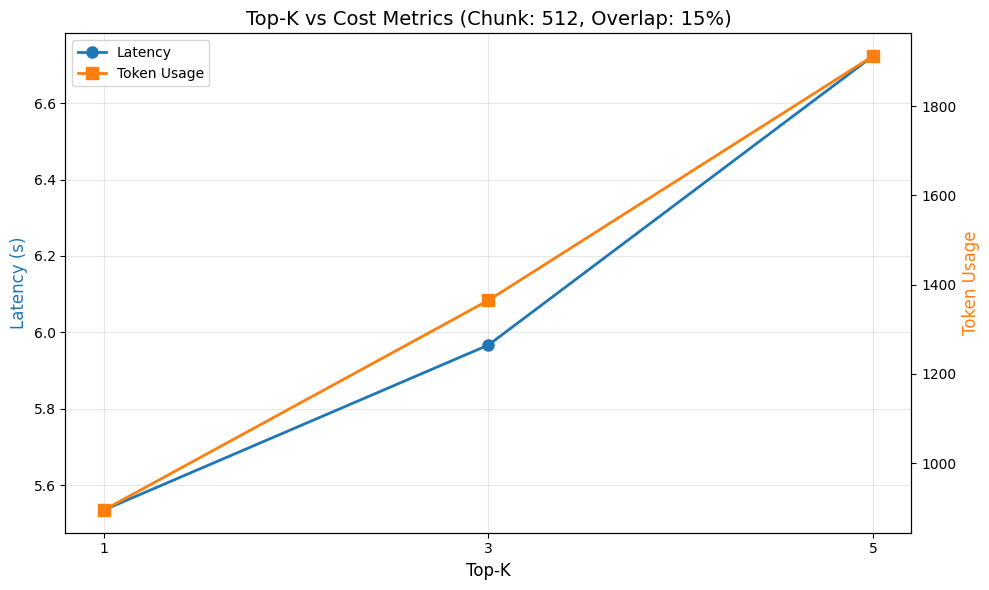

In [90]:
df_filtered = df[df['namespace'] == 'cs512-ov15']
topk_means = df_filtered.groupby('top_k')[['latency', 'total_tokens']].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

line1, = ax1.plot(topk_means.index, topk_means['latency'], marker='o',
                  linewidth=2, markersize=8, color='tab:blue', label='Latency')
line2, = ax2.plot(topk_means.index, topk_means['total_tokens'], marker='s',
                  linewidth=2, markersize=8, color='tab:orange', label='Token Usage')

ax1.set_xlabel('Top-K', fontsize=12)
ax1.set_ylabel('Latency (s)', fontsize=12, color='tab:blue')
ax2.set_ylabel('Token Usage', fontsize=12, color='tab:orange')
ax1.set_title('Top-K vs Cost Metrics (Chunk: 512, Overlap: 15%)', fontsize=14)
ax1.set_xticks([1, 3, 5])
ax1.grid(True, alpha=0.3)
ax1.legend([line1, line2], ['Latency', 'Token Usage'], loc='best')

plt.tight_layout()
plt.show()

## 3. Chunk Size vs 품질 (Top-K 3 / Overlap 15%)

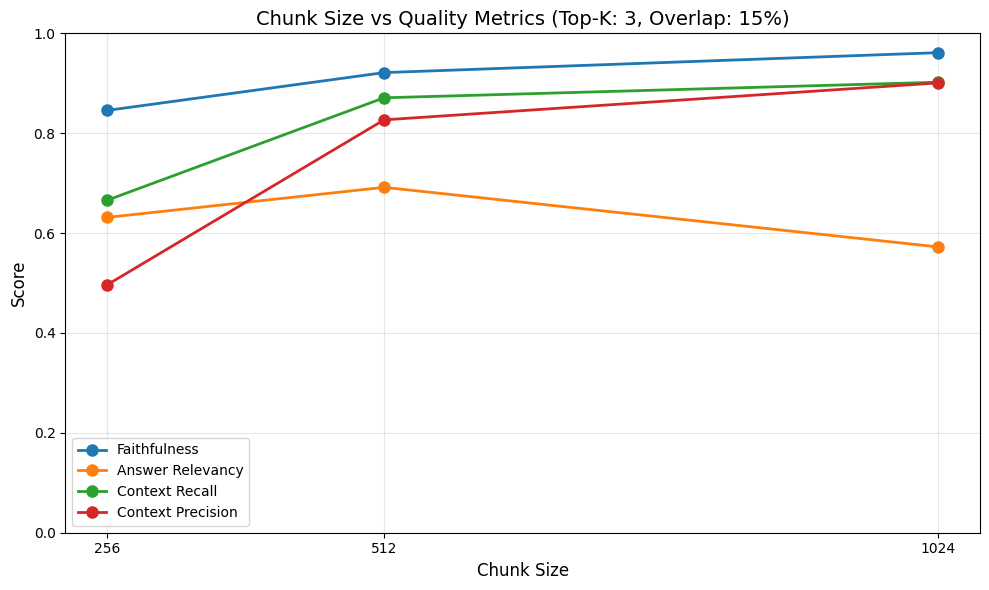

In [91]:
metrics = ['faithfulness', 'answer_correctness',
           'context_recall', 'context_precision']
labels = ['Faithfulness', 'Answer Relevancy',
          'Context Recall', 'Context Precision']
chunk_sizes = [256, 512, 1024]

df_filtered = df[(df['top_k'] == 3) & (df['namespace'].str.contains('ov15'))]
df_filtered = df_filtered.copy()
df_filtered['chunk_size'] = df_filtered['namespace'].str.extract(
    r'cs(\d+)').astype(int)
chunk_means = df_filtered.groupby('chunk_size')[metrics].mean()

plt.figure(figsize=(10, 6))
for metric, label in zip(metrics, labels):
    plt.plot(chunk_means.index, chunk_means[metric],
             marker='o', linewidth=2, markersize=8, label=label)

plt.xlabel('Chunk Size', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Chunk Size vs Quality Metrics (Top-K: 3, Overlap: 15%)', fontsize=14)
plt.xticks(chunk_sizes)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Chunk Size vs 비용 (Top-K 3 / Overlap 15%)

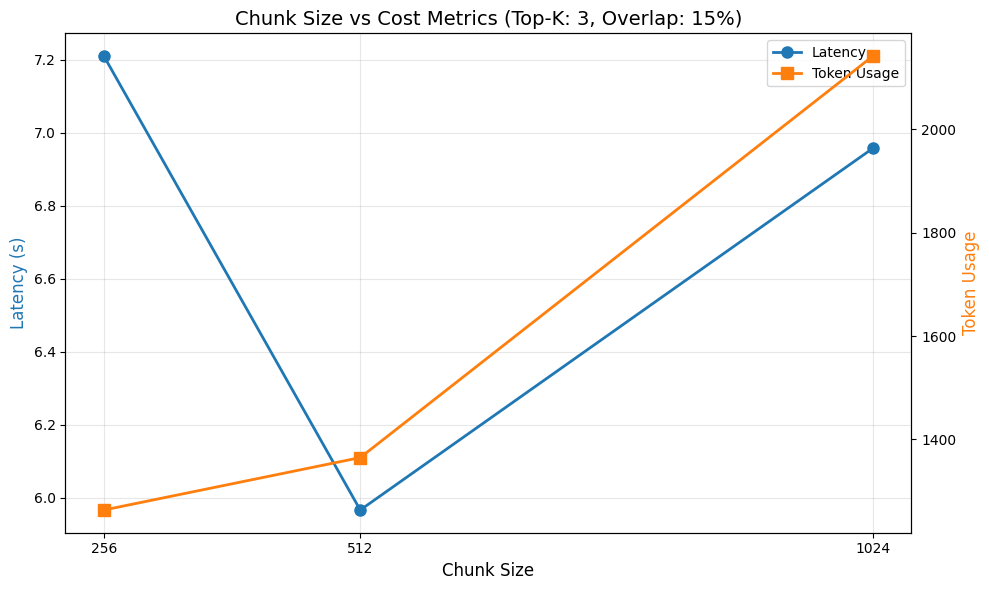

In [92]:
chunk_sizes = [256, 512, 1024]

df_filtered = df[(df['top_k'] == 3) & (df['namespace'].str.contains('ov15'))]
df_filtered = df_filtered.copy()
df_filtered['chunk_size'] = df_filtered['namespace'].str.extract(
    r'cs(\d+)').astype(int)
chunk_means = df_filtered.groupby(
    'chunk_size')[['latency', 'total_tokens']].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

line1, = ax1.plot(chunk_means.index, chunk_means['latency'], marker='o',
                  linewidth=2, markersize=8, color='tab:blue', label='Latency')
line2, = ax2.plot(chunk_means.index, chunk_means['total_tokens'], marker='s',
                  linewidth=2, markersize=8, color='tab:orange', label='Token Usage')

ax1.set_xlabel('Chunk Size', fontsize=12)
ax1.set_ylabel('Latency (s)', fontsize=12, color='tab:blue')
ax2.set_ylabel('Token Usage', fontsize=12, color='tab:orange')
ax1.set_title(
    'Chunk Size vs Cost Metrics (Top-K: 3, Overlap: 15%)', fontsize=14)
ax1.set_xticks(chunk_sizes)
ax1.grid(True, alpha=0.3)
ax1.legend([line1, line2], ['Latency', 'Token Usage'], loc='best')

plt.tight_layout()
plt.show()

## 5. Overlap vs 품질 (Top-K 3 / Chunk 512)

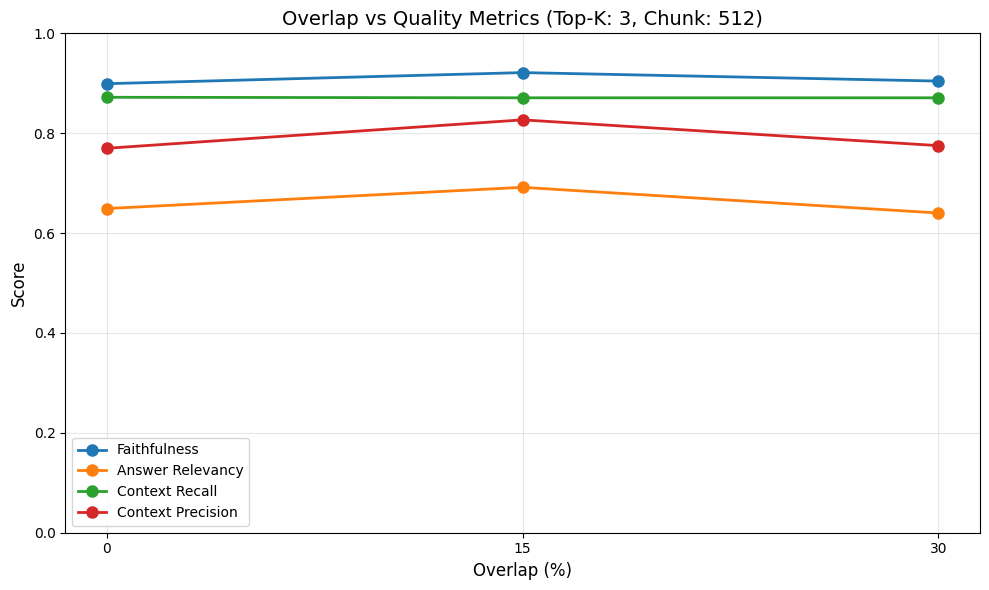

In [93]:
metrics = ['faithfulness', 'answer_correctness',
           'context_recall', 'context_precision']
labels = ['Faithfulness', 'Answer Relevancy',
          'Context Recall', 'Context Precision']
overlaps = [0, 15, 30]

df_filtered = df[(df['top_k'] == 3) & (df['namespace'].str.contains('cs512'))]
df_filtered = df_filtered.copy()
df_filtered['overlap'] = df_filtered['namespace'].str.extract(
    r'ov(\d+)').astype(int)
overlap_means = df_filtered.groupby('overlap')[metrics].mean()

plt.figure(figsize=(10, 6))
for metric, label in zip(metrics, labels):
    plt.plot(overlap_means.index,
             overlap_means[metric], marker='o', linewidth=2, markersize=8, label=label)

plt.xlabel('Overlap (%)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Overlap vs Quality Metrics (Top-K: 3, Chunk: 512)', fontsize=14)
plt.xticks(overlaps)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Overlap vs 비용 (Top-K 3 / Chunk 512)

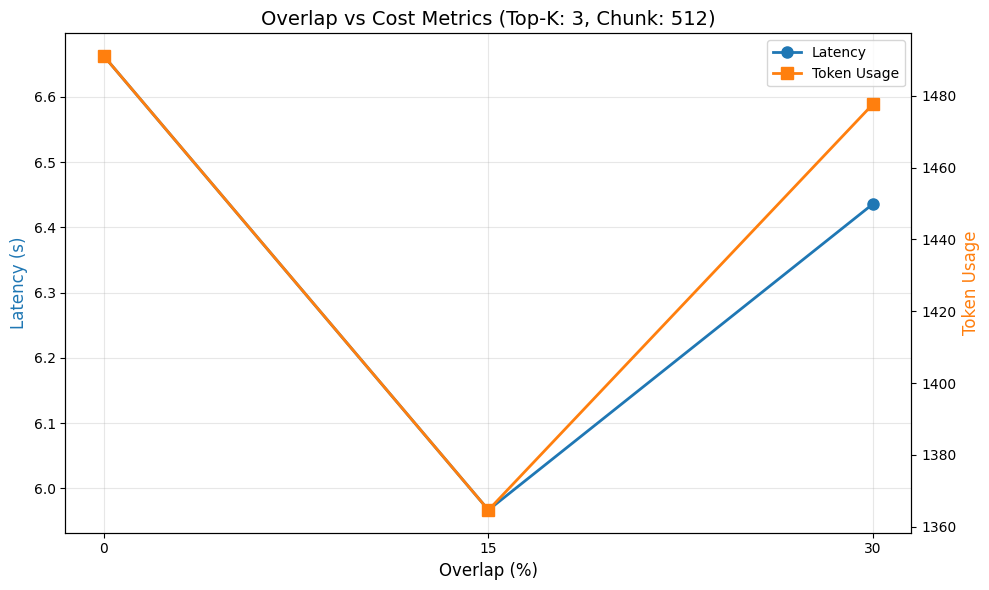

In [94]:
overlaps = [0, 15, 30]

df_filtered = df[(df['top_k'] == 3) & (df['namespace'].str.contains('cs512'))]
df_filtered = df_filtered.copy()
df_filtered['overlap'] = df_filtered['namespace'].str.extract(
    r'ov(\d+)').astype(int)
overlap_means = df_filtered.groupby(
    'overlap')[['latency', 'total_tokens']].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

line1, = ax1.plot(overlap_means.index, overlap_means['latency'], marker='o',
                  linewidth=2, markersize=8, color='tab:blue', label='Latency')
line2, = ax2.plot(overlap_means.index, overlap_means['total_tokens'], marker='s',
                  linewidth=2, markersize=8, color='tab:orange', label='Token Usage')

ax1.set_xlabel('Overlap (%)', fontsize=12)
ax1.set_ylabel('Latency (s)', fontsize=12, color='tab:blue')
ax2.set_ylabel('Token Usage', fontsize=12, color='tab:orange')
ax1.set_title('Overlap vs Cost Metrics (Top-K: 3, Chunk: 512)', fontsize=14)
ax1.set_xticks(overlaps)
ax1.grid(True, alpha=0.3)
ax1.legend([line1, line2], ['Latency', 'Token Usage'], loc='best')

plt.tight_layout()
plt.show()